# Sep yale-th, 2021

**Motivation**: This has the most succesfull registration of Nissl to Yale N162 0.1 mm <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import Allen
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice(Config(17, resolution=25), load_preproc=True)

In [3]:
from register.register import *
reg = Register(mice)

In [4]:
reg.in_house

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (100.0, 100.0, 100.0)
         Origin     : (-7.8, -6.2, 6.4)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7fa7768f8100>

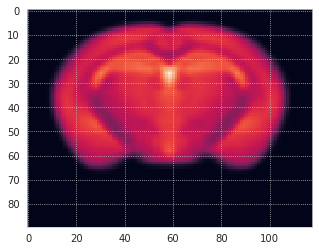

In [5]:
plt.imshow(reg.in_house[78])

<matplotlib.image.AxesImage object at 0x7fa73017b400>

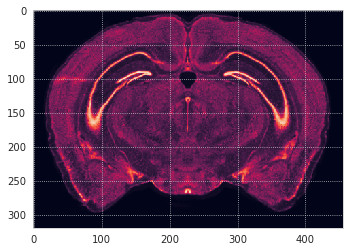

In [6]:
plt.imshow(reg.nissl[78 * 4])

In [8]:
reg.ccf_to_inhouse(reg.nissl, dtype='float32')

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (456, 320, 528)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [9]:
tx = reg.load_tx('Symmetric_N162', '3d', True)
tx

[
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF-3d_ants-inv.mat',
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF-3d_ants-inv.nii.gz'
]

In [10]:
tx_aff = pjoin('_sep30', 'Symmetric_N162_space-CCF-3d_ants-aff.mat')
tx_aff = ants.read_transform(tx_aff, 3)
tx_aff

ANTsTransform
         Type       : AffineTransform
         Dimension  : 3
         Precision  : float

In [11]:
yale_affined = tx_aff.apply_to_image(reg.in_house, reg.nissl, 'linear')

In [12]:
obj = reg.apply2objects(
    obj_fixed=None,
    moving=yale_affined,
    moving_orig=reg.in_house,
    tx_aff=tx_aff,
    tx=tx,
    # tx={'invtransforms': tx},
)

In [13]:
obj

{
    'misc': ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (100.0, 100.0, 100.0)
         Origin     : (-7.8, -6.2, 6.4)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
,
    'iso': ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (100.0, 100.0, 100.0)
         Origin     : (-7.8, -6.2, 6.4)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
,
    'hemis': ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (100.0, 100.0, 100.0)
         Origin     : (-7.8, -6.2, 6.4)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

}

In [16]:
iso_lps = reg.ccf_to_inhouse(obj['iso'], 0.1)

In [18]:
ants.image_write(iso_lps, f"./_sep30/iso_lps_jadid.nii.gz")

In [43]:
for k, v in obj.items():
    ants.image_write(v, f"./_sep30/{k}.nii.gz")

In [44]:
for k, v in obj.items():
    lps = reorient_arr(v.numpy(), reg.tr_axes)
    lps = lps[..., ::-1]
    lps = reset_ants_img(lps, spacing=0.1, dtype='uint32')
    ants.image_write(lps, f"./_sep30/{k}_lps.nii.gz")

In [25]:
obj = reg.apply2objects(
    obj_fixed={
        'roi': reg.img_in_ccf(mice.parcel.results['cortex']),
        'roi_eroded': reg.img_in_ccf(mice.parcel.results['cortex_eroded'])},
    moving=yale_affined,
    moving_orig=reg.in_house,
    tx_aff=tx_aff,
    tx={'invtransforms': tx},
)

In [26]:
obj['roi_eroded']

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (100.0, 100.0, 100.0)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7e298b7b8640>

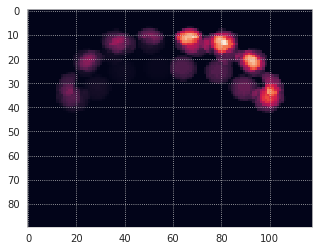

In [27]:
plt.imshow(obj['roi_eroded'].mean(0))

In [28]:
for k, v in obj.items():
    ants.image_write(v, f"./_sep30/{k}.nii.gz")

In [30]:
for k, v in obj.items():
    lps = reorient_arr(v.numpy(), reg.tr_axes)
    lps = lps[..., ::-1]
    lps = reset_ants_img(lps, spacing=0.1, dtype='uint32')
    ants.image_write(lps, f"./_sep30/{k}_lps.nii.gz")

## Now do one individual

In [40]:
key = 'sub-SLC06_ses-1'
indiv_lps = mice.T1w[key].load_ants()
ants.image_write(indiv_lps, f"./_sep30/{key}_lps.nii.gz")

In [41]:
indiv_lps

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [39]:
mice.T1w[key].load_ants()

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [46]:
os.listdir('./_sep30/SLC/ses-1')

[
    'hemis_SLC06-01.nii.gz',
    'roi_eroded_SLC06-01.nii.gz',
    'roi_eroded_SLC06-01_2D.nii.gz',
    'misc_SLC06-01.nii.gz',
    'iso_SLC06-01.nii.gz'
]

In [47]:
hemis = ants.image_read(pjoin('./_sep30/SLC/ses-1', 'hemis_SLC06-01.nii.gz'))
iso = ants.image_read(pjoin('./_sep30/SLC/ses-1', 'iso_SLC06-01.nii.gz'))
misc = ants.image_read(pjoin('./_sep30/SLC/ses-1', 'misc_SLC06-01.nii.gz'))

In [48]:
hemis

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [49]:
iso

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [50]:
misc

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [54]:
m_l = hemis.numpy() == 1
m_r = hemis.numpy() == 2
m_l.sum(), m_r.sum()

(50514, 48378)

In [55]:
symmetry_score(iso.numpy().astype(bool), m_l, m_r)

0.9934510815638024

In [58]:
scores = {}

xxx = np.unique(reg.objects['misc'].numpy())
xxx = [int(e) for e in xxx if e > 0]
xxx = reg.mice.al.get(xxx)
xxx = dict(zip(xxx['acronym'], xxx['id']))
xxx = {
    k: misc.numpy() == i
    for k, i in xxx.items()
}
xxx['iso'] = iso.numpy().astype(bool)

for key, x in xxx.items():
    scores[f"sym_{key}"] = symmetry_score(x, m_l, m_r)
scores = {
    k: 0.0 if np.isnan(s) else s
    for k, s in scores.items()
}

_ = xxx.pop('iso')

vox = reg.mice.al.get_masks(list(xxx), False)
vox = {k: v.astype(bool).sum() for k, v in vox.items()}
sym, ovp = 0, 0
for key, size in vox.items():
    sym += size * scores[f"sym_{key}"]
scores.update({
    'sym': sym / sum(vox.values()),
})

In [59]:
scores

{
    'sym_MOp': 0.9566160520607375,
    'sym_MOs': 0.9278752436647173,
    'sym_SS': 0.927122464312547,
    'sym_VISC': 0.9636363636363636,
    'sym_VIS': 0.975328947368421,
    'sym_AI': 0.9504132231404958,
    'sym_PTLp': 0.9101123595505618,
    'sym_TEa': 0.8873239436619719,
    'sym_CA1': 0.9020332717190388,
    'sym_CLA': 0.7037037037037037,
    'sym_STRd': 0.9271623672230652,
    'sym_iso': 0.9934510815638024,
    'sym': 0.9329344380550535
}

<matplotlib.image.AxesImage object at 0x7e297901faf0>

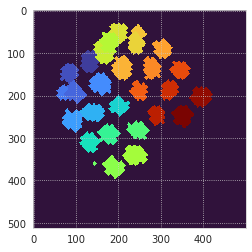

In [73]:
roi_2d = ants.image_read(pjoin('./_sep30/SLC/ses-1', 'roi_eroded_SLC06-01_2D.nii.gz'))
roi_2d = roi_2d.numpy().astype('uint32')
plt.imshow(roi_2d.squeeze(), cmap='turbo')

<matplotlib.image.AxesImage object at 0x7e2979181a30>

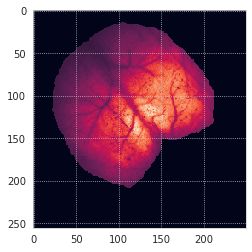

In [74]:
key = 'sub-SLC06_ses-1'
ref = mice.ref[key].get_data()
plt.imshow(ref)

In [157]:
from skimage.measure import block_reduce

In [158]:
x = block_reduce(roi_2d.squeeze(), block_size=(2, 2), func=np.nanmax)
x = x.astype('uint32')

<matplotlib.image.AxesImage object at 0x7e27e0cea340>

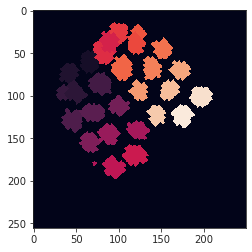

In [159]:
plt.imshow(x)

In [160]:
np.unique(x)

array([ 0,  2,  3,  4,  5,  6,  7,  8, 10, 11, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 33, 34], dtype=uint32)

In [165]:
len(np.unique(x))

29

In [161]:
np.unique(mice.parcel.results2d['cortex_eroded'])

array([ 0,  1,  3,  4,  6,  7,  8, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21,
       23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34], dtype=uint32)

In [164]:
len(np.unique(mice.parcel.results2d['cortex_eroded']))

28

In [173]:
aaa = set(np.unique(mice.parcel.results2d['cortex_eroded'])).intersection(set(np.unique(x)))
len(aaa)

25

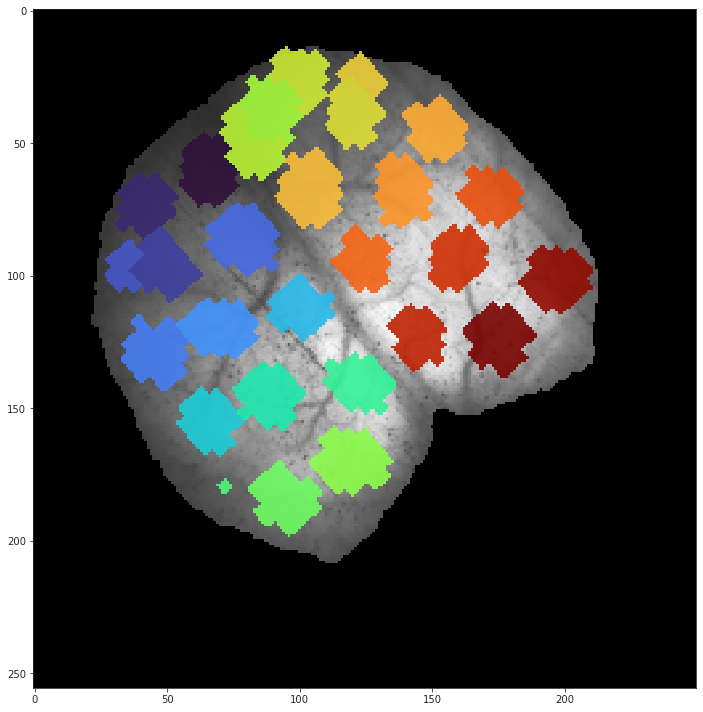

In [174]:
fig, ax = create_figure(1, 1, (12, 10))
ax.imshow(ref, cmap='Greys_r')
ax.imshow(np.ma.masked_where(~x.astype(bool), x), alpha=0.9, cmap='turbo')
plt.show()

In [201]:
mice.al.mcc.resolution

25

In [9]:
key = 'sub-SLC10_ses-3'

In [10]:
indiv = mice.T1w[key].load_ants()
indiv

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [11]:
mask = mice.mask3d[key].load_ants()
mask

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [12]:
mice.mask3d[key].nii_file

'sub-SLC10_ses-3_space-individual_desc-mask_bold.nii.gz'

<matplotlib.image.AxesImage object at 0x7fa5d52b1eb0>

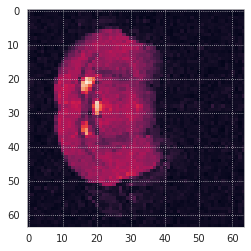

In [13]:
plt.imshow(indiv[..., 40])

In [14]:
indiv *= mask

<matplotlib.image.AxesImage object at 0x7fa5d50b9b20>

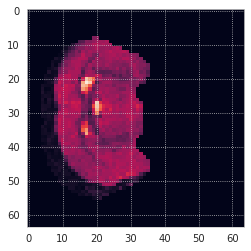

In [15]:
plt.imshow(indiv[..., 40])

In [19]:
indiv_prep

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (78, 64, 64)
         Spacing    : (200.0, 200.0, 200.0)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [16]:
indiv_prep = reg._prepare(indiv)

<matplotlib.image.AxesImage object at 0x7fa5d49640d0>

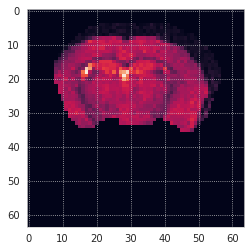

In [18]:
plt.imshow(indiv_prep[40])

In [216]:
indiv

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [217]:
np.array(indiv)

array(ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, dtype=object)

In [221]:
indiv.origin

(6.400000095367432, -6.200000286102295, -7.800000190734863)

In [222]:
indiv.spacing

(0.20000000298023224, 0.20000000298023224, 0.20000000298023224)

In [223]:
indiv.dtype

'float32'

In [225]:
reg.in_house_name

'Symmetric_N162'

In [226]:
resolution = 100
spacing_mm = resolution / 1000
file = [
    f"{reg.in_house_name}",
    f"{spacing_mm:.2f}.nii.gz",
]
file = '_'.join(file)
file = pjoin(
    reg.mice.cfg.base_dir, 'Yale',
    'atlases_templates', file,
)
img = ants.image_read(file)

In [227]:
img

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (118, 90, 160)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [20]:
org = (6.4, -6.2, -7.8)

In [21]:
reg.tr_axes

(2, 1, 0)

In [22]:
tuple(org[i] for i in reg.tr_axes)

(-7.8, -6.2, 6.4)

In [220]:
indiv.direction

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

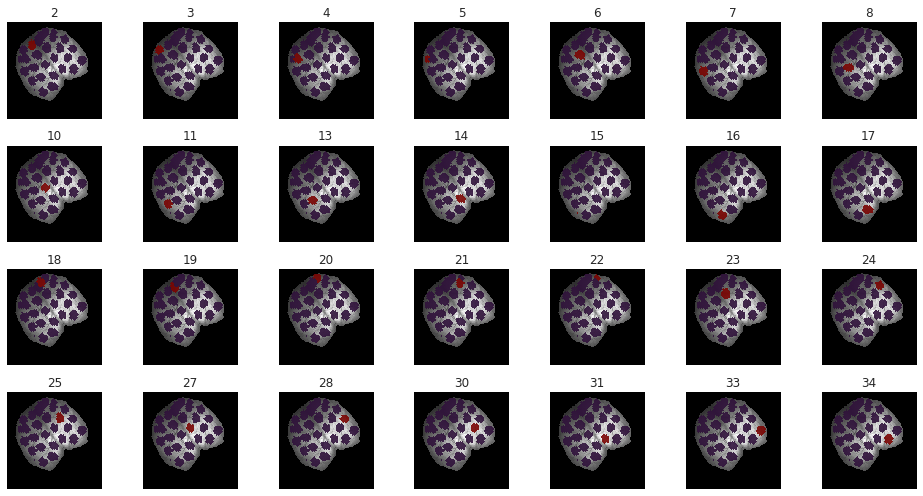

In [189]:
fig, axes = create_figure(4, 7, (13.5, 7))

for i, ax in zip(np.unique(x[x > 0]), axes.ravel()):
    ax.imshow(ref, cmap='Greys_r')
    ax.imshow(np.ma.masked_where(~x.astype(bool), x == i), alpha=0.9, cmap='turbo')
    ax.set_title(i)
remove_ticks(axes)
plt.show()

In [190]:
counts = {}
for i in np.unique(x[x > 0]):
    counts[i] = (x == i).sum()

<AxesSubplot:ylabel='Count'>

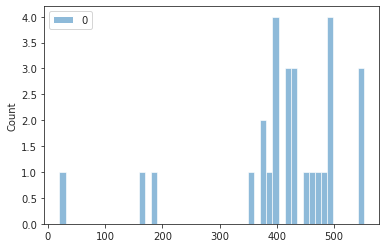

In [193]:
sns.histplot(counts.values(), bins=50)

In [197]:
np.mean(list(counts.values())), np.std(list(counts.values()))

(411.07142857142856, 115.1725192208344)

In [198]:
np.mean(list(counts.values())) - 3 * np.std(list(counts.values()))

65.55387090892532

In [181]:
mice = Mice(Config(17, resolution=25), load_preproc=True)

<matplotlib.image.AxesImage object at 0x7e295c085e20>

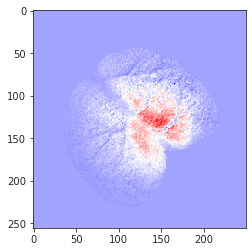

In [183]:
ca = mice.ca_preproc['sub-SLC01_ses-1_run-1'].get_data()
plt.imshow(ca[..., 10], cmap='bwr')

In [184]:
ca.shape

(256, 250, 6000)